In [1]:
import pandas as pd
import openpyxl
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from statistics import median,mean,mode
import pickle
from helper import get_tweets_from_db, get_tweets_from_file

pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'nltk'

In [ ]:
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user.screen_name"]

    # The interactions are going to be a set of tuples
    interactions = set()
    
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add(row["in_reply_to_screen_name"])
    # After that, we add the interactions with retweets
    interactions.add(row["retweeted_status.user.screen_name"])
    # And later, the interactions with user mentions
    interactions.add(row["user_mentions_screen_name"])
    
    # Discard if user id is in interactions
    interactions.discard(row["user.screen_name"])
    # Discard all not existing values
    interactions.discard(None)
    # Return user and interactions
    return user, interactions

In [ ]:
# tweets_final = get_tweets_from_db()
tweets_final = get_tweets_from_file()

In [ ]:
graph = nx.Graph()

for index, tweet in tweets_final.iterrows():
    user, interactions = get_interactions(tweet)
    user_name = user
    
    tweet_id = tweet["id"]
    sentiment = tweet["nlp_score"]
    
    #tweet_sent = tweet["sentiment"]
    for interaction in interactions:
        int_name = interaction
        graph.add_edge(user_name, int_name, tweet_id=tweet_id, sentiment=sentiment)
        
        graph.nodes[user_name]["name"] = user_name
        graph.nodes[int_name]["name"] = int_name    

In [ ]:

# save graph object to file
# pickle.dump(graph, open('graph_format.pickle', 'wb'))

In [ ]:
# nx.write_gexf(graph, "tweets_graph.gexf")

In [ ]:
#plt.figure(figsize = (20,20))
#nx.draw(graph, pos=pos, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
#nx.draw_networkx_nodes(graph, pos=pos, node_size=300)
#plt.show()

In [ ]:
#nx.draw_kamada_kawai(graph,alpha=0.3, node_size=[d[k] for k in d])

In [ ]:
tweets_final.max(axis=0)['nlp_score']

/var/folders/7v/vvhj3q5s1v55226yr2qhczyc0000gn/T/ipykernel_47384/3092797245.py:1: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  tweets_final.max(axis=0)['nlp_score']


0.9892

In [ ]:
tweets_final.min(axis=0)['nlp_score']

/var/folders/7v/vvhj3q5s1v55226yr2qhczyc0000gn/T/ipykernel_47384/3205438357.py:1: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  tweets_final.min(axis=0)['nlp_score']


-0.9904

In [ ]:
#WHAT YOU CAN USE DIRECTLY

# tweets_final = pd.read_pickle("tweets_final_df_formatted.pkl")   #to get the final well processed dataframe
# then use #17 #18 cells to make the basic simple graph

#or load directly the graph
# G = nx.read_gpickle("graph_format.gpickle")

In [ ]:
M = nx.MultiGraph()

In [ ]:
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user.screen_name"]

    # The interactions are going to be a set of tuples
    interactions = set()
    
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add(row["in_reply_to_screen_name"])
    # After that, we add the interactions with retweets
    interactions.add(row["retweeted_status.user.screen_name"])
    # And later, the interactions with user mentions
    interactions.add(row["user_mentions_screen_name"])
    
    # Discard if user id is in interactions
    interactions.discard(row["user.screen_name"])
    # Discard all not existing values
    interactions.discard(None)
    # Return user and interactions
    return user, interactions

In [ ]:
for index, tweet in tqdm(tweets_final.iterrows()):
    user, interactions = get_interactions(tweet)
    user_name = user
    
    tweet_id = tweet["id"]
    sentiment = tweet["nlp_score"]
    
    #tweet_sent = tweet["sentiment"]
    for interaction in interactions:
        int_name = interaction
        M.add_edge(user_name, int_name, tweet_id=tweet_id, sentiment=sentiment)
        
        M.nodes[user_name]["name"] = user_name
        M.nodes[int_name]["name"] = int_name  

0it [00:00, ?it/s]

In [ ]:
M.number_of_nodes()

395734

In [ ]:
M.number_of_edges()

986005

In [ ]:
#Converting into a simple graph with single edges and summing sentiment + number of edges grouped
G = nx.Graph()
for u,v,data in tqdm(M.edges(data=True)):
    score = data['sentiment']
    if G.has_edge(u,v):
        G[u][v]['sentiment'] += score
        G[u][v]['interactions'] += 1
        
    else:
        G.add_edge(u, v, sentiment =score , interactions = 1)
        

  0%|          | 0/986005 [00:00<?, ?it/s]

In [ ]:
def normalize_rgb_green_red(value):
    r = -255*value/2 + 255/2
    g = 255*value/2 + 255/2
    b =  255/2 - 255/2 * value * value
    
    dict_rgb = {'r': int(r), 'g': int(g), 'b': int(b), 'a': 0.7}
    return(dict_rgb)

In [ ]:
#Averaging the sentiment and computing color accordingly
for u,v,data in tqdm(G.edges(data=True)):
    avg = G[u][v]['sentiment'] / G[u][v]['interactions']
    G[u][v]['average_sentiment'] =  avg
    G[u][v]['viz'] = {"color": normalize_rgb_green_red(avg) }
        

  0%|          | 0/907168 [00:00<?, ?it/s]

In [ ]:
#This is for the gephi software
nx.write_gexf(G, "tweets_graph_color.gexf")

In [ ]:
#This saves the graph in a pickle file
pickle.dump(G, open('graph_format.pickle', 'wb'))

#If you want to load it directly without doing the steps above :
#G = nx.read_gpickle('graph_format.pickle')

In [ ]:
G.number_of_nodes()

395734

In [ ]:
G.number_of_edges()

907168

In [ ]:
def plot_degree_distribution(dmin,dmax,degree_sequenc,log=False):
        #Creating a vector containing all possible integers from min_s to max_s
        v = np.linspace(dmin, dmax, dmax)

        #Binning the random numbers into the generated vector
        nb, bins = np.histogram(degree_sequence,v)
        
        #We convert the bins output in an array of same lenght as the count to be able to plot a scatter plot
        bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(nb))]
        fig, ax = plt.subplots()
        fig.set_figheight(2)
        ax.scatter(bins_mean, nb, s=5)
        ax.set_xlabel("k")
        ax.set_ylabel("count")
        
        if log:
            ax.set_yscale('log')
            ax.set_xscale('log')


1
32582


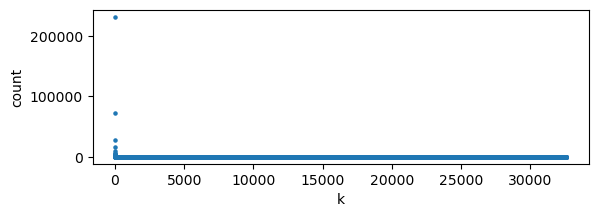

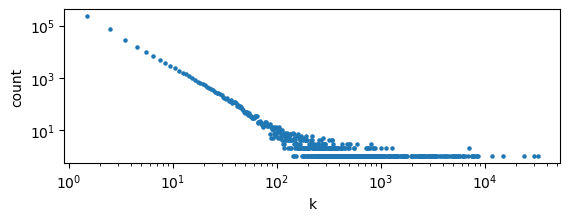

In [ ]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmin = min(degree_sequence)
print(dmin)
dmax = max(degree_sequence)
print(dmax)

plot_degree_distribution(dmin,dmax,degree_sequence,log=False)
plot_degree_distribution(dmin,dmax,degree_sequence,log=True)

In [ ]:
degrees = [item[1] for item in list(G.degree())]
print("---Statistics for in-degree---")
print("Average degree ",mean(degrees))
print("Median degree ",median(degrees))
print("Mode degree ",median(degrees))
print("Max degree ",max(degrees))
print("Min degree ",min(degrees))


---Statistics for in-degree---
Average degree  4.584736211697757
Median degree  1.0
Mode degree  1.0
Max degree  32582
Min degree  1


In [ ]:
d = dict(G.degree)
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

In [ ]:
senators_pd = pd.read_excel("congress_twitter.xlsx") 

In [ ]:
list_senators = senators_pd .to_dict('records')

In [ ]:
accounts = {'democrats':0,'democrats_interactions':0,'republicans':0,'republicans_interactions':0}
for senator in list_senators:
    if senator['Username'] in d:
        if senator['Party'] == 'R':
            accounts['republicans'] += 1
            accounts['republicans_interactions'] += d[senator['Username']]
        elif senator['Party'] == 'D':
            accounts['democrats'] += 1
            accounts['democrats_interactions'] += d[senator['Username']]
accounts 

{'democrats': 51,
 'democrats_interactions': 1210,
 'republicans': 55,
 'republicans_interactions': 2689}

# Communities 

In [ ]:
import networkx as nx
import networkx.algorithms.community as nx_comm


In [ ]:
communities = nx_comm.louvain_communities(G)

In [ ]:
com = list(nx_comm.louvain_partitions(G))

In [ ]:
len(communities)

12719

In [ ]:
communities.sort(key=len, reverse=True)


In [ ]:
top_communities = communities[:10]

In [ ]:
print("Lenght of communities: ")
for i, community in enumerate(top_communities):
    print("Community {} has length {}".format(i + 1, len(community)))
    

Lenght of communities: 
Community 1 has length 81201
Community 2 has length 60791
Community 3 has length 45958
Community 4 has length 18107
Community 5 has length 17440
Community 6 has length 12846
Community 7 has length 12241
Community 8 has length 12073
Community 9 has length 11961
Community 10 has length 7020


In [ ]:
color_list = [
    {"a":0.7, "r": 244, "g": 67, "b": 54},  # Red
    {"a":0.7, "r": 236, "g": 64, "b": 122},  # Pink 
    {"a":0.7, "r": 156, "g": 39, "b": 176}, # Purple
    {"a":0.7, "r": 63, "g": 81, "b": 181},  # Indigo 
    {"a":0.7, "r": 33, "g": 150, "b": 243}, # Blue
    {"a":0.7, "r": 0, "g": 150, "b": 136},  # Teal
    {"a":0.7, "r": 76, "g": 175, "b": 80},  # Green
    {"a":0.7, "r": 255, "g": 235, "b": 59}, # Yellow 
    {"a":0.7, "r": 96, "g": 125, "b": 139}, # Blue Grey
    {"a":0.7, "r": 0, "g": 188, "b": 212},  # Cyan
]  

In [ ]:
# comparing all the nodes in the graph with the nodes in the top 10 communities, and assigning them a color for visualization
for v in tqdm(nx.nodes(G)):
    for i, c in enumerate(top_communities):
        if v in c:
            G.nodes[v]["viz"]={}
            G.nodes[v]["viz"]["color"] = color_list[i]
    

  0%|          | 0/395734 [00:00<?, ?it/s]

In [ ]:
# check for overlap in top 10 communities
for c in top_communities:
    for cc in top_communities:
        if c is cc:
            continue
        overlap = c.intersection(cc)
        if overlap:
            print("There is an overlap of the following nodes:")
            print(overlap)

In [ ]:
from networkx.algorithms.community import modularity

mod = modularity(G,communities )

print("The modularity for the communities is {}".format(mod))


The modularity for the communities is 0.5885193388546219


# Sentiment Analysis

In [ ]:
G_1 = G.subgraph(top_communities[0])
G_2 = G.subgraph(top_communities[1])
G_3 = G.subgraph(top_communities[2])
G_4 = G.subgraph(top_communities[3])
G_5 = G.subgraph(top_communities[4])
G_6 = G.subgraph(top_communities[5])
G_7 = G.subgraph(top_communities[6])
G_8 = G.subgraph(top_communities[7])
G_9 = G.subgraph(top_communities[8])
G_10 = G.subgraph(top_communities[9])


In [ ]:
tweets_final.iloc[0]

created_at                                              Tue Nov 15 19:39:34 +0000 2022
id                                                                 1592603232098209793
in_reply_to_status_id                                                             None
in_reply_to_screen_name                                                           None
retweeted_status.id                                                               None
retweeted_status.user.screen_name                                              Admone7
user_mentions_screen_name                                                         None
full_text                            RT @Admone7: Isn’t it strange how in just abou...
user.screen_name                                                       DeniseD38011087
nlp_score                                                                      -0.6597
Name: 0, dtype: object

In [ ]:
tweets_final[tweets_final['user.screen_name'] == "DeniseD38011087"]

,created_at,id,in_reply_to_status_id,in_reply_to_screen_name,retweeted_status.id,retweeted_status.user.screen_name,user_mentions_screen_name,full_text,user.screen_name,nlp_score
0,Tue Nov 15 19:39:34 +0000 2022,1592603232098209793,None,None,None,Admone7,None,RT @Admone7: Isn’t it strange how in just abou...,DeniseD38011087,-0.6597
78679,Mon Nov 14 23:48:11 +0000 2022,1592303411604881408,None,None,None,larryelder,None,RT @larryelder: #Midterms https://t.co/V3xWY59RDW,DeniseD38011087,0.0000
804962,Thu Nov 10 00:03:02 +0000 2022,1590495210504884225,None,None,None,larryelder,None,RT @larryelder: Let me get this straight. 72% ...,DeniseD38011087,-0.2441


In [ ]:
df_community_1 = tweets_final.loc[tweets_final['user.screen_name'].isin(top_communities[0])]

In [ ]:
print(len(df_community_1.index))
print(len(top_communities[0]))

152987
81201


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(df_community_1["user.screen_name"].values.tolist())
# feature_names = vectorizer.get_feature_names_out()
# dense = vectors.todense()
# denselist = dense.tolist()
# df_td_idf = pd.DataFrame(denselist, columns=feature_names)

: 

: 